In [1]:
import pandas as pd
import regex as re
import torch
from transformers import BertTokenizer, BertModel
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import metrics
from sklearn.datasets import make_blobs
from collections import Counter
import pickle
import copy
import nltk
from nltk.corpus import stopwords
import string

## DATA CLEANING (can skip this part when you already have the clean file)

In [2]:
# Import the data
data = pd.read_csv('DATI1.csv', sep = ";")

In [3]:
data

,#,Source,Definition
0,1,Aldersgate (2012),A circular economy is a restorative industrial...
1,2,"Allwood, Ashby, Gutowski, & Worrell (2011, p. ...",The UK government has extensively promoted a w...
2,3,"Andersen (2007, p. 133)",The concept of a circular economy – currently ...
3,4,"Augustsson, Sörme, Karlsson, & Amneklev (2017,...",A circular economy aims to reduce the inﬂow of...
4,5,"Bai, Qiao, Yao, Guo, & Xie (2014, p. 6)","In 2006, the style of NDEIPs changed to a ‘cir..."
...,...,...,...
108,110,"Zhang et al. (2009, p. 264)",Circular economy is a mode of economic develop...
109,111,"Zhijun & Nailing (2007, p. 95)","The circular economy, which is a mode of econo..."
110,112,"Zhu, Geng, & Lai (2010, p. 1324)",The CE model has been implemented at three lev...
111,113,"Zhu, Zhou, Cui, & Liu (2010, p. 4821)",Industrial solid waste recycling accords with ...


In [4]:
# Restructure the column 'Source', to split author from year
data[['Author', 'Year']] = data['Source'].str.extract(r'(.*?)\s*\((\d{4})', expand=True)
data = data.drop('Source', axis=1)

In [5]:
# Removing unwanted strings
data['Author'] = data['Author'].str.replace(" \(", "")
data['Year'] = data['Year'].str.replace(" \(", "").str.replace(" p. ...", "")

C:\Users\anato\AppData\Local\Temp/ipykernel_21324/2892112458.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Author'] = data['Author'].str.replace(" \(", "")
C:\Users\anato\AppData\Local\Temp/ipykernel_21324/2892112458.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Year'] = data['Year'].str.replace(" \(", "").str.replace(" p. ...", "")


Cleaning 'definition' column:

In [6]:
data = data.iloc[:, 1:]

In [7]:
data = data.sort_values(by='Year', ascending=True)

In [8]:
data['Year'] = data['Year'].replace('2005', '2006')

In [9]:
definition = data.iloc[:, 0]

In [10]:
clean_text = []
for row in definition:
    clean_row = row.lower()
    clean_row = re.sub(r'\([^)]*\)', '', clean_row)
    clean_row = re.sub(r'-', ' ', clean_row)
    clean_row = clean_row.replace("‘", "").replace("’", "")
    clean_row = clean_row.replace("“", "").replace("”", "")
    clean_rows = clean_row.replace("[", "").replace("]", "")
    clean_text.append(clean_rows)

In [11]:
texts = list(clean_text)

In [12]:
text_upgraded = []
for text in texts:
    text = text.replace(' ce ', ' circular economy ')
    ##text = text.replace('ce ', ' circular economy ')
    text_upgraded.append(text)

In [13]:
count = 0
for text in text_upgraded:
    if ' ce ' in text:
        count += 1
print(count)

0


In [14]:
count = 0
for text in text_upgraded:
    if '[' in text:
        count += 1
print(count)

0


In [15]:
len(text_upgraded)

113

In [16]:
# Removing stop words
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
cleaned_sentences = []

for sentence in text_upgraded:
    no_punct = ''.join([char for char in sentence if char not in string.punctuation])
    words = no_punct.split()
    cleaned_sentence = ' '.join([word for word in words if word.lower() not in stops])
    cleaned_sentences.append(cleaned_sentence)

In [18]:
len(cleaned_sentences)

113

In [19]:
data['Clean Definitions'] = cleaned_sentences 

In [20]:
data['Clean Definitions']

105    circular economy also called recycling economy...
21     thinking economy closed system opposed linear ...
107    although commonly accepted definition circular...
2      concept circular economy – currently widely pr...
109    circular economy mode economic development bas...
                             ...                        
34     define circular economy regenerative system re...
78     strategy informed circular economy principles ...
79     support economic growth sustainable resource m...
63     circular economy economic model wherein planni...
112    concept circular economy gained signiﬁcant tra...
Name: Clean Definitions, Length: 113, dtype: object

In [ ]:
# Save the updated dataset in a csv file
data.to_csv('data_tesi.csv')

## Upload the clean dataset (once you have the embeddings file you can skip this part)

In [21]:
data = pd.read_csv('data_tesi.csv')

In [22]:
data['Counts'] = data['Clean Definitions'].str.lower().str.count('circular economy')

In [ ]:
# Removes all texts where the number of times 'circular economy' does not appear, it's optional 
data = data[data['Counts'] != 0]

In [23]:
data['Clean Definitions'][71]

'purpose economic analysis circular economy defined economy provides multiple value creation mechanisms decoupled consumption finite resources definition rests three principles preserve enhance natural capital controlling finite stocks balancing renewable resource flows – example replacing fossil fuels renewable energy returning nutrients ecosystems optimise resource yields circulating products components materials use highest utility times technical biological cycles – example sharing looping products extending product lifetimes foster system effectiveness revealing designing negative externalities water air soil noise pollution climate change toxins congestion negative health effects related resource use narrower notions circular economy limited material reuse sometimes regeneration exist modern economy requires applying three principles reintegrate economy planets system ultimate ambition circular thinking thus applying principles means creating economy restorative regenerative pres

In [24]:
data[data['Year'] == 2008]['Clean Definitions']

8     term circular economy mentioned measures gener...
9     therefore chinas idea circular economy charact...
10    organising economic activities closed loop mat...
11    chinese people chosen use term circular econom...
Name: Clean Definitions, dtype: object

In [25]:
data[data['Year'] == 2017]['Clean Definitions'].count()

25

In [26]:
## create lists of definitions for each year
clust = {}

for year, defin in zip(data['Year'], data['Clean Definitions']):
    if year in clust:
        clust[year].append(defin)
    else:
        clust[year] = [defin]

# Extract BERT embeddings for 'circular economy' (once you have the embeddings file you can skip this part)

In [28]:
from transformers import AutoTokenizer, AutoModel
class TextProcessor:
    """
        Handles text processing, tokenization, embeddings extraction, 
        and year-wise text analysis using a BERT transformer model.
    """
    def __init__(self, model_name='bert-base-uncased'):
        self.tokenizer, self.model = self.setup_model(model_name)
    
    def setup_model(self, model_name):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if not tokenizer.is_fast:  # Controlla se il tokenizer è "fast"
            raise ValueError(f"Tokenizer is not fast. Fast tokenizer required for {model_name}")
        
        model = AutoModel.from_pretrained(model_name)
        return tokenizer, model
    
    def get_embeddings_and_tokens(self, text):
        '''
        Computes the embeddings and tokens for each text, in each year
        '''
        encoded_inputs = self.tokenizer.encode_plus(
            text,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=512,
            return_offsets_mapping=True  
        )

        outputs = self.model(**{k: v for k, v in encoded_inputs.items() if k != 'offset_mapping'})  # Esclude gli offset dagli input al modello
        last_hidden_states = outputs.last_hidden_state
        
        tokens = self.tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'].flatten())

        offset_mapping = encoded_inputs['offset_mapping']

        return last_hidden_states, tokens, offset_mapping

    def indexing(self, tokens, target_phrase):
        '''
        Creates indices for target words and non-target words
        '''
        target_tokens = self.tokenizer.tokenize(target_phrase)
        
        indices_tp = []
        for i in range(len(tokens) - len(target_tokens) + 1):
            if tokens[i:i+len(target_tokens)] == target_tokens:
                indices_tp += list(range(i, i + len(target_tokens)))
        
        indices_ntp = [idx for idx in range(len(tokens)) if idx not in indices_tp]

        return indices_tp, indices_ntp
    
    def extract_embeddings_by_year(self, clust_dict, target_phrase):
        '''
        Structuring the dictionary 'embeddings_by_year' as:
        
        embeddings_by_year[year] = {
        
                "embeddings": embeddings_list, 
                "tokens": tokens_list,
                "indices_tp": indices_tp_year,
                "indices_ntp": indices_ntp_year,
                "offset_mappings": offset_mappings_list
            }
        '''
        embeddings_by_year = {}
        
        for year, texts in clust_dict.items():
            embeddings_list = []
            tokens_list = []
            offset_mappings_list = []
            indices_tp_year = []
            indices_ntp_year = []

            for text in texts:
                embeddings, tokens, offset_mapping = self.get_embeddings_and_tokens(text)
                indices_tp, indices_ntp = self.indexing(tokens, target_phrase)
                
                embeddings_list.append(embeddings.squeeze(0))
                tokens_list.append(tokens)
                offset_mappings_list.append(offset_mapping)
                indices_tp_year.append(indices_tp)
                indices_ntp_year.append(indices_ntp)
            
            embeddings_by_year[year] = {
                "embeddings": embeddings_list, 
                "tokens": tokens_list,
                "indices_tp": indices_tp_year,
                "indices_ntp": indices_ntp_year,
                "offset_mappings": offset_mappings_list
            }
            print(f"Year: {year}, Texts processed: {len(texts)}, Embeddings & indices calculated.")
        return embeddings_by_year

In [29]:
target_phrase = 'circular economy'
processor = TextProcessor()

In [30]:
embeddings_by_year = processor.extract_embeddings_by_year(clust, target_phrase)

Year: 2006, Texts processed: 3, Embeddings & indices calculated.
Year: 2007, Texts processed: 5, Embeddings & indices calculated.
Year: 2008, Texts processed: 4, Embeddings & indices calculated.
Year: 2009, Texts processed: 3, Embeddings & indices calculated.
Year: 2010, Texts processed: 5, Embeddings & indices calculated.
Year: 2011, Texts processed: 9, Embeddings & indices calculated.
Year: 2012, Texts processed: 9, Embeddings & indices calculated.
Year: 2013, Texts processed: 12, Embeddings & indices calculated.
Year: 2014, Texts processed: 15, Embeddings & indices calculated.
Year: 2015, Texts processed: 12, Embeddings & indices calculated.
Year: 2016, Texts processed: 11, Embeddings & indices calculated.
Year: 2017, Texts processed: 25, Embeddings & indices calculated.


In [ ]:
## SAVE FILE
with open('Downloads/embeddings_by_year (10).pkl', 'wb') as file:
     pickle.dump(embeddings_by_year, file)

# Compute the avg embeddings for the target phrase

In [31]:
## OPEN FILE
import pickle
with open('Downloads\embeddings_by_year (10).pkl', 'rb') as file:
      embeddings_by_year = pickle.load(file)

In [32]:
for year, data in embeddings_by_year.items():
    for embeddings, tokens in zip(data['embeddings'], data['tokens']):
        if embeddings.size(0) != len(tokens):
            print(f"Mismatch in lengths for embeddings and tokens: {embeddings.size(0)} vs. {len(tokens)}")

In [33]:
for year, data in embeddings_by_year.items():
    all_indices_per_text = []  
    for idx_tp, idx_ntp in zip(data['indices_tp'], data['indices_ntp']):
        indexes = idx_tp + idx_ntp  
        unique_indexes = sorted(list(set(indexes))) 
        
        all_indices_per_text.append(unique_indexes)
    data['indices'] = all_indices_per_text

In [34]:
for year, data in embeddings_by_year.items():
    for embeddings, indexes in zip(data['embeddings'], data['indices']):
        if embeddings.size(0) != len(indexes):
            print(f"Mismatch in lengths for embeddings and indexes: {embeddings.size(0)} vs. {len(indexes)}")

In [35]:
class EmbeddingProcessor:
    """
   Computes the average embedding for the target expression 'circular economy' and updates tokens, and indices accordingly.
    
    """
    def __init__(self, embeddings_by_year):
        self.original_embeddings_by_year = embeddings_by_year
        self.embeddings_by_year = copy.deepcopy(embeddings_by_year)

    def calc_mean_embedding_for_ce(self):
        '''
        Calculate average embeddings for "circular economy" and update indices accordingly.
        '''
        for year, data in self.embeddings_by_year.items():
            new_embeddings_list = []  # Lista per contenere gli embeddings aggiornati frasali

            for embeddings, text_indices in zip(data['embeddings'], data['indices_tp']):
                embeddings = embeddings.detach().clone()
                indices_to_remove = []

                with torch.no_grad():
                # Single occurence
                    if len(text_indices) == 2:
                        target_embeddings = embeddings[text_indices[0]:text_indices[1]+1]
                        mean_embedding = torch.mean(target_embeddings, dim=0)
                        embeddings[text_indices[0]] = mean_embedding
                        indices_to_remove.append(text_indices[1])

                    # More occurrences
                    elif len(text_indices) > 2:
                        pairs = [text_indices[i:i+2] for i in range(0, len(text_indices), 2)]
                        for pair in pairs:
                            target_embeddings = embeddings[pair[0]:pair[1]+1]
                            mean_embedding = torch.mean(target_embeddings, dim=0)
                            embeddings[pair[0]] = mean_embedding
                            indices_to_remove.append(pair[1])

                    indices_to_keep = [i for i in range(len(embeddings)) if i not in indices_to_remove]

                    new_embeddings = embeddings[indices_to_keep]
                    new_embeddings_list.append(new_embeddings)
                data['embeddings'] = new_embeddings_list

    def aggregate_tokens(self):
        '''
        Aggregation of the tokens 'circular' & 'economy' in 'circular economy'
        '''
        for year, defs in self.embeddings_by_year.items():
            updated_tokens = []  

            for doc_tokens in defs['tokens']: 
                new_tokens = [] 
                i = 0
                while i < len(doc_tokens):
                    if i < len(doc_tokens) - 1 and doc_tokens[i].lower() == "circular" and doc_tokens[i+1].lower() == "economy":
                        new_tokens.append("circular economy")
                        i += 2  
                    else:
                        new_tokens.append(doc_tokens[i])
                        i += 1

                updated_tokens.append(new_tokens)

            defs['tokens'] = updated_tokens  # Aggiorna i token per l'anno corrente con le versioni aggregate
    
    def update_indices_tp(self):
        '''
        Updates the indices of the target expression 'circular econmy'
        '''
        for year, data in self.embeddings_by_year.items():
            original_indices = data['indices_tp']
            new_indices_tp = []
            
            for group in original_indices:
                if not group:
                    continue

                new_group = []
                if len(group) > 2:
                    for i in range(0, len(group), 2):
                        adjustment = i//2
                        new_index = group[i] - adjustment
                        new_group.append(new_index)
                else:
                        new_group.append(group[0])
                    
                new_indices_tp.append(new_group)    

            data['indices_tp'] = new_indices_tp
            
    def update_indices_ntp(self):
        '''
        Updates the indices of all other words: 2 steps solution (for x[0] != 0 and x[i+1] != x[i]+1)
        '''
        for year, data in self.embeddings_by_year.items():
            indx = data['indices_ntp']
            updated_indices = [] 

            for x in indx:
                if x[0] != 0:
                    updated_indices.append([xi - 1 for xi in x])
                else:
                    updated_indices.append(x)

            data['indices_ntp'] = updated_indices

        for year, data in self.embeddings_by_year.items():
            indx = data['indices_ntp']
            updated_indices = []

            for x in indx:
                for i in range(0, len(x)-1):
                    if x[i + 1] != x[i] + 1:
                        x = x[:i+1] + [xi - 1 for xi in x[i+1:]]
                updated_indices.append(x)

            data['indices_ntp'] = updated_indices
    
    def update_tot_indices(self):
        '''
        Aggregation of the 2 indices lists
        '''
        for year, data in self.embeddings_by_year.items():
            all_indices_per_text = []  
            for idx_tp, idx_ntp in zip(data['indices_tp'], data['indices_ntp']):
                indexes = idx_tp + idx_ntp  
                unique_indexes = sorted(list(set(indexes))) 
        
                all_indices_per_text.append(unique_indexes)
            data['indices'] = all_indices_per_text

    def process(self):
        '''
        Call all methods
        '''
        self.calc_mean_embedding_for_ce()
        self.aggregate_tokens()
        self.update_indices_tp()
        self.update_indices_ntp()
        self.update_tot_indices()
        
        return self.embeddings_by_year

In [36]:
processor = EmbeddingProcessor(embeddings_by_year)
updated_embeddings_by_year = processor.process()

In [37]:
for year, data in updated_embeddings_by_year.items():
    for embeddings, tokens in zip(data['embeddings'], data['tokens']):
        if embeddings.size(0) != len(tokens):
            print(f"Mismatch in lengths for embeddings and tokens: {embeddings.size(0)} vs. {len(tokens)}")

In [38]:
for year, data in updated_embeddings_by_year.items():
    for embeddings, indices in zip(data['embeddings'], data['indices']):
        if embeddings.size(0) != len(indices):
            print(f"Mismatch in lengths for embeddings and indices: {embeddings.size(0)} vs. {len(indices)}, year = {year}")

Mismatch in lengths for embeddings and indices: 35 vs. 38, year = 2011
Mismatch in lengths for embeddings and indices: 89 vs. 85, year = 2011
Mismatch in lengths for embeddings and indices: 54 vs. 53, year = 2011
Mismatch in lengths for embeddings and indices: 29 vs. 28, year = 2012
Mismatch in lengths for embeddings and indices: 31 vs. 30, year = 2012
Mismatch in lengths for embeddings and indices: 43 vs. 42, year = 2012
Mismatch in lengths for embeddings and indices: 63 vs. 60, year = 2013
Mismatch in lengths for embeddings and indices: 26 vs. 27, year = 2013
Mismatch in lengths for embeddings and indices: 56 vs. 54, year = 2013
Mismatch in lengths for embeddings and indices: 43 vs. 42, year = 2013
Mismatch in lengths for embeddings and indices: 29 vs. 28, year = 2013
Mismatch in lengths for embeddings and indices: 26 vs. 24, year = 2014
Mismatch in lengths for embeddings and indices: 65 vs. 64, year = 2014
Mismatch in lengths for embeddings and indices: 68 vs. 67, year = 2014
Mismat

# Compute the 'evolution' matrix, showcasing the evolution of the similarities between 'circular economy' and  significant words

In [40]:
def cosine_similarity(a, b):
    '''Computes cosine similarity between 2 embedded vectors'''
    similarity =  torch.nn.functional.cosine_similarity(a, b, dim=0)
    return similarity

In [41]:
def unite_tokens(tokens):
    '''
    Unites interrupted words into the whole word
    '''
    words = []
    current_word = ''

    for tok in tokens:
        if tok.startswith('##'):
            current_word += tok[2:] 
        else:
            if current_word:  
                words.append(current_word)
            current_word = tok 
    if current_word:  
        words.append(current_word)

    return words

In [42]:
def find_closest_words(embeddings_by_year):
    """
    Identifies and ranks the words closest in embedding space to "circular economy" for each year, 
    excluding 'tokens_to_exclude'.
    """
    
    closest_words_by_year = {}

    tokens_to_exclude = ['circular economy', '[SEP]', '[CLS]', '[PAD]', '–']

    for year, data in embeddings_by_year.items():
        year_closest_words = []

        for embeddings, tokens, indices in zip(data['embeddings'], data['tokens'], data['indices']):
            united_tokens = unite_tokens(tokens) # Combines tokenized entities into single tokens 
            ce_indices = [i for i, token in enumerate(united_tokens) if token == 'circular economy']

            for ce_index in ce_indices:
                try:
                    target_embedding = embeddings[ce_index].unsqueeze(0)
                    
                    # Obtains embeddings and tokens, excluding "circular economy" token.
                    embeddings_except_target = torch.cat([embeddings[:ce_index], embeddings[ce_index+1:]])
                    tokens_except_target = united_tokens[:ce_index] + united_tokens[ce_index+1:]
                    
                    #Computes the cosine similarity between target vectors and other embedded vectors
                    similarities = cosine_similarity(target_embedding, embeddings_except_target)
                    
                    # Filter out specified tokens and sort remaining by their similarity scores.
                    words_similarity = [
                        (token, sim) for token, sim in zip(tokens_except_target, similarities.numpy()) 
                        if token not in tokens_to_exclude
                    ]

                    sorted_words_similarity = sorted(words_similarity, key=lambda x: x[1], reverse=True)
                    
                    year_closest_words.append((united_tokens[ce_index], sorted_words_similarity))
                except IndexError:
                    continue
        
        closest_words_by_year[year] = year_closest_words
        
    return closest_words_by_year

In [43]:
top_words = find_closest_words(updated_embeddings_by_year)

In [44]:
soglia_di_similarità = 7

for year, words_info in top_words.items():
    print(f"Year: {year}")
    for target_word, closest_words in words_info:
        print(f"Target Phrase: '{target_word}'")
        
        close_words = [word_info for word_info in closest_words if word_info[1] > soglia_di_similarità]
        for word, similarity in close_words:
            print(f" - {word}: {similarity:.4f}")
    print("\n")

Year: 2006
Target Phrase: 'circular economy'
Target Phrase: 'circular economy'
Target Phrase: 'circular economy'
Target Phrase: 'circular economy'


Year: 2007
Target Phrase: 'circular economy'
Target Phrase: 'circular economy'
 - economy: 7.3604
 - natural: 7.2839
 - economic: 7.1347
Target Phrase: 'circular economy'
Target Phrase: 'circular economy'
Target Phrase: 'circular economy'
 - resources: 7.6736
 - community: 7.3001
 - paths: 7.1457
Target Phrase: 'circular economy'
 - utilization: 7.6255
 - integrated: 7.3169
 - either: 7.0059
Target Phrase: 'circular economy'
 - utilization: 7.6170
 - integrated: 7.2954
 - paths: 7.1211


Year: 2008
Target Phrase: 'circular economy'
 - resources: 7.8066
 - term: 7.4455
 - directly: 7.2906
 - follow: 7.0792
 - circulation: 7.0504
 - saving: 7.0171
Target Phrase: 'circular economy'
 - consumption: 7.8060
 - materials: 7.2706
 - follow: 7.1081
 - production: 7.0641
Target Phrase: 'circular economy'
 - consumption: 7.8172
 - consumption: 7.4415

In [45]:
# Select several words that could be useful to be analyzed
word_to_analyse = set(['nature', 'environmental', 'product', 'resources', 'sustainable', 'consumption', 'reuse', 'recycle', 'recycling','production', 'development',
                       'saving', 'consumption', 'production','secondhand','efficiency', 'society', 'policies', 'institutions', 'reduction', 'leadership', 'growth', 'utilization', 'capital', 'service', 'decouple', 'waste', 'regenerative', 'value', 'quality', 'reuse' ])

df = pd.DataFrame(columns=word_to_analyse)
len(word_to_analyse)

28

In [46]:
# Creates an 'evolutionary' matrix, taking the words to analyse (as result of the previous steps) for analyzing 
# the similarity evolutions between circular economy and other significant words
for year, word_lists in top_words.items():
    scores_for_year = {word: None for word in word_to_analyse}  # Uso word_to_analyse
    
    for _, closest_words in word_lists:
        for word, similarity in closest_words:
            if word in word_to_analyse: 
                if (scores_for_year[word] is None) or (similarity > scores_for_year[word]):
                    scores_for_year[word] = similarity
    
    df = pd.concat([df, pd.DataFrame([scores_for_year], index=[year])], axis=0)

df.fillna(0, inplace=True)

In [47]:
df

,saving,capital,value,nature,quality,waste,efficiency,reduction,growth,society,...,leadership,decouple,production,policies,sustainable,regenerative,institutions,service,secondhand,recycling
2006,0.000000,0.000000,0.000000,0.000000,0.000000,-1.995882,0.000000,0.238185,0.000000,0.000000,...,0.000000,0.000000,3.764491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.890133
2007,0.000000,0.000000,0.000000,0.000000,0.000000,2.158309,3.392340,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.504724,0.000000,6.610572,1.416992,0.000000,0.000000,0.000000,6.007074
2008,7.017075,0.000000,4.066265,10.387295,0.000000,9.071983,7.275255,-2.664614,0.000000,7.302565,...,0.000000,0.000000,7.367278,0.000000,2.044785,0.000000,0.000000,6.389122,0.000000,6.598020
2009,8.368565,0.000000,0.000000,0.000000,0.000000,0.021294,0.827790,8.221742,8.900323,6.279481,...,8.885827,4.219082,-3.739317,0.000000,-4.512886,0.000000,0.000000,0.000000,0.000000,3.463244
2010,0.000000,0.000000,6.179660,0.000000,0.000000,6.247017,6.842565,1.331049,1.882968,7.183778,...,0.000000,0.000000,6.064473,2.757166,0.000000,0.000000,0.000000,0.000000,0.000000,7.537005
2011,6.248336,0.000000,0.000000,0.000000,0.000000,4.898800,3.337946,0.898386,0.000000,0.000000,...,0.000000,0.000000,6.629486,7.348735,2.469191,0.000000,7.247415,0.000000,0.000000,0.000000
2012,0.000000,0.000000,3.072336,0.000000,3.924495,3.301647,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.462393,0.000000,4.753189,0.000000,0.000000,0.000000,0.000000
2013,0.000000,1.686600,4.463513,-1.728317,0.000000,4.061091,0.000000,0.000000,0.000000,3.788171,...,0.000000,0.000000,4.377513,0.000000,0.000000,6.035515,0.000000,0.000000,0.000000,6.331325
2014,0.000000,0.000000,4.818056,5.797012,0.000000,6.455097,1.819339,4.973288,6.542039,4.927243,...,0.000000,0.000000,3.318938,0.000000,7.711700,6.371398,0.000000,2.264790,0.000000,1.885553
2015,0.000000,7.795109,6.630569,5.023695,0.000000,5.647614,-0.914721,6.860257,10.186809,0.000000,...,0.000000,2.241369,4.499228,0.000000,5.629954,6.605929,0.000000,3.314043,0.000000,2.158209


In [48]:
# Extracts the words with the highest scores (overall and 'lately') 
highest_scores_ovall = df.sum().sort_values(ascending=False).head(10)
highest_scores_lately = df.loc[2013:].sum().sort_values(ascending=False).head(10)

print(highest_scores_ovall)
print('--------------------------')
print(highest_scores_lately)

resources        64.582619
waste            53.964767
recycling        53.717598
production       51.905041
development      50.522785
reuse            50.183636
product          49.735142
value            48.293522
environmental    46.827618
growth           38.522675
dtype: float32
--------------------------
value           34.975258
reuse           32.998814
regenerative    31.923309
waste           30.261597
resources       29.494877
product         28.581341
growth          27.739382
production      26.313900
sustainable     26.016182
development     25.437965
dtype: float32


In [50]:
# df_hso, final matrix for most significant words 
highest_scores = ['resources', 'waste', 'recycling', 'production', 'sustainable','development', 'reuse', 'product', 'value', 'environmental', 'growth', 'regenerative', ]
df_hso = df[highest_scores]

In [51]:
df_hso

,resources,waste,recycling,production,sustainable,development,reuse,product,value,environmental,growth,regenerative
2006,1.763066,-1.995882,5.890133,3.764491,0.000000,-2.298856,1.973638,0.000000,0.000000,0.000000,0.000000,0.000000
2007,7.673624,2.158309,6.007074,5.504724,6.610572,5.872868,0.000000,6.708714,0.000000,0.000000,0.000000,1.416992
2008,7.806597,9.071983,6.598020,7.367278,2.044785,9.434771,3.316276,6.445321,4.066265,10.029106,0.000000,0.000000
2009,4.874933,0.021294,3.463244,-3.739317,-4.512886,5.070293,0.000000,0.000000,0.000000,6.574088,8.900323,0.000000
2010,7.141171,6.247017,7.537005,6.064473,0.000000,3.611096,8.078314,7.999768,6.179660,4.940399,1.882968,0.000000
2011,5.297078,4.898800,0.000000,6.629486,2.469191,3.394648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012,0.531274,3.301647,0.000000,0.000000,0.000000,0.000000,3.816591,0.000000,3.072336,0.000000,0.000000,4.753189
2013,4.082935,4.061091,6.331325,4.377513,0.000000,3.364060,6.364116,4.346654,4.463513,3.859568,0.000000,6.035515
2014,3.549820,6.455097,1.885553,3.318938,7.711700,6.379561,7.488108,5.612489,4.818056,5.845633,6.542039,6.371398
2015,9.927141,5.647614,2.158209,4.499228,5.629954,5.141438,6.179089,5.445374,6.630569,2.991633,10.186809,6.605929


# Plotting the evolution of similarity scores of significant words with 'circular economy'

In [52]:
colors = [
    'blue', 'green', 'red', 'purple', 'orange',
    'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'teal' 
]

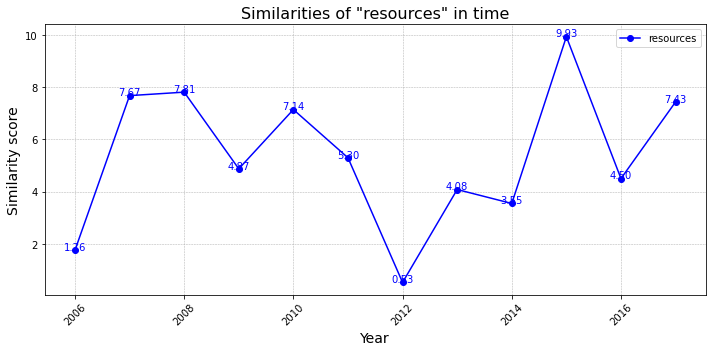

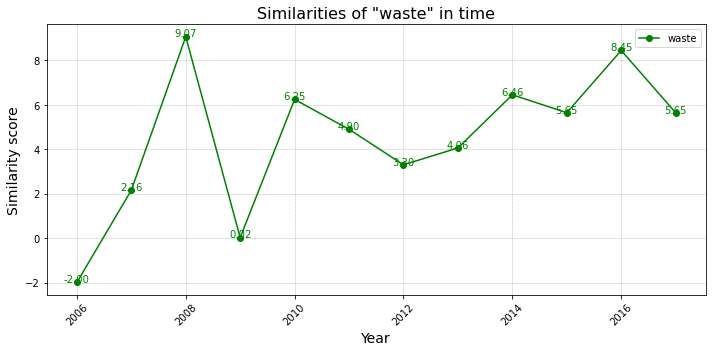

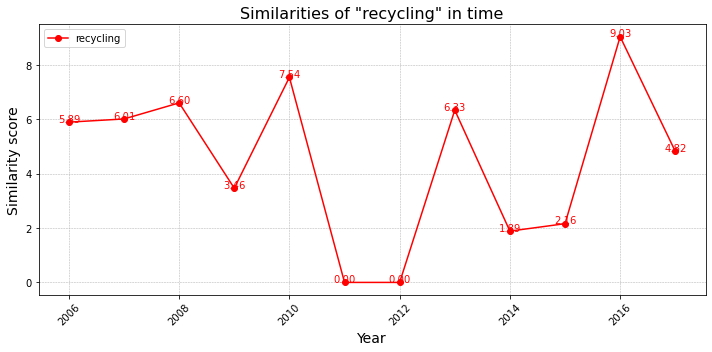

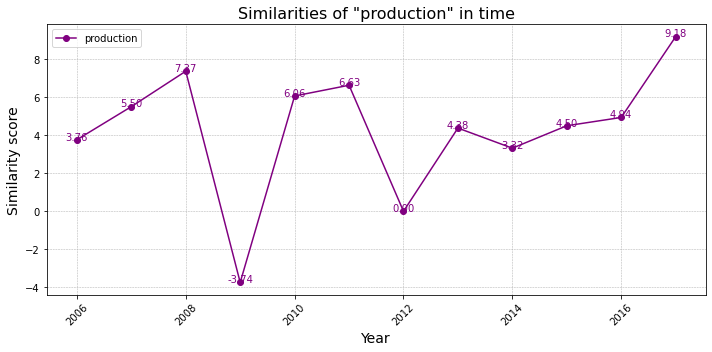

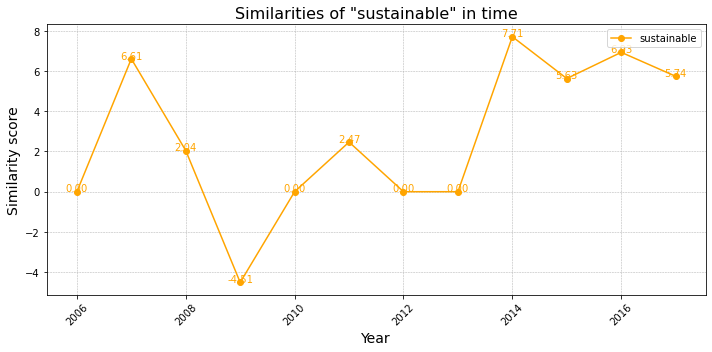

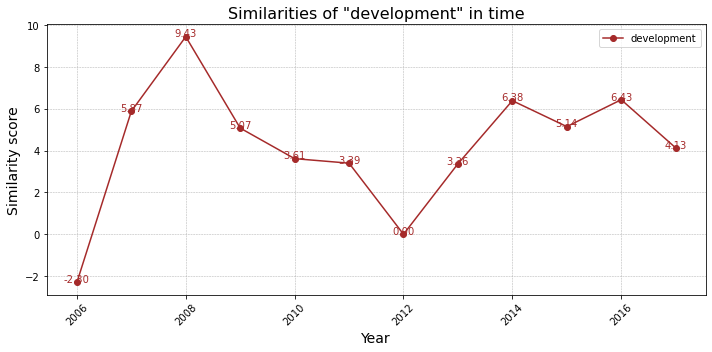

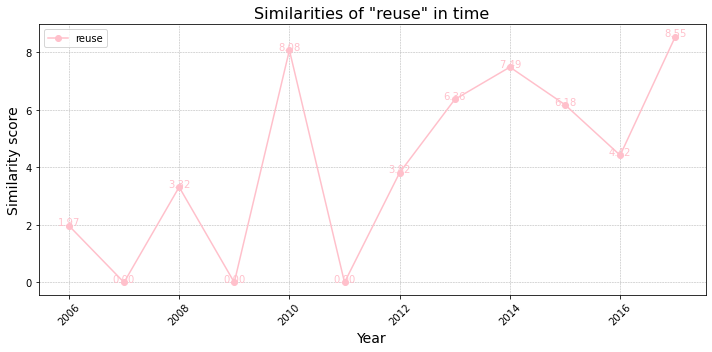

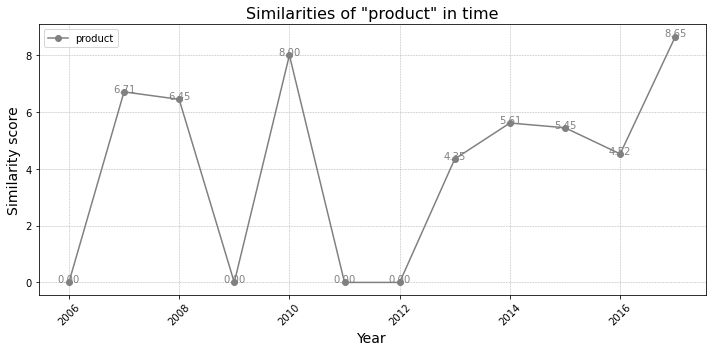

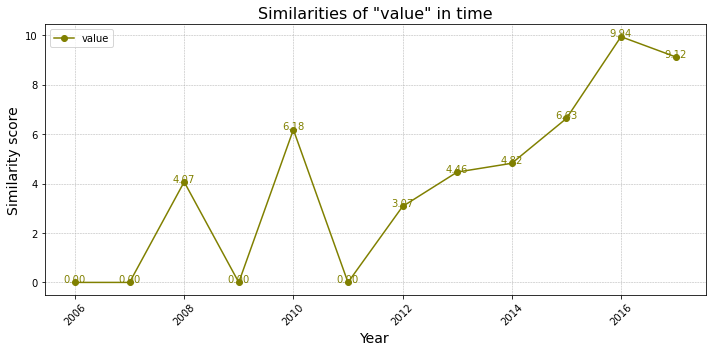

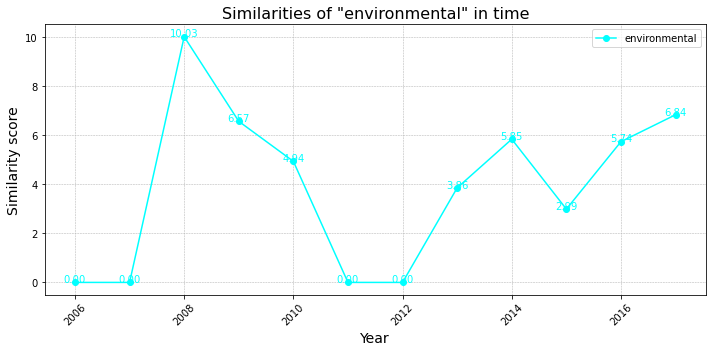

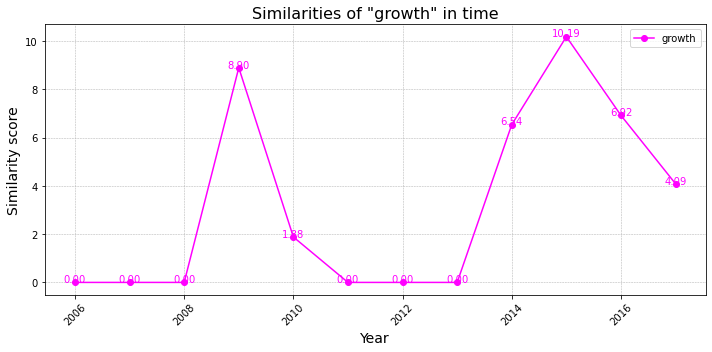

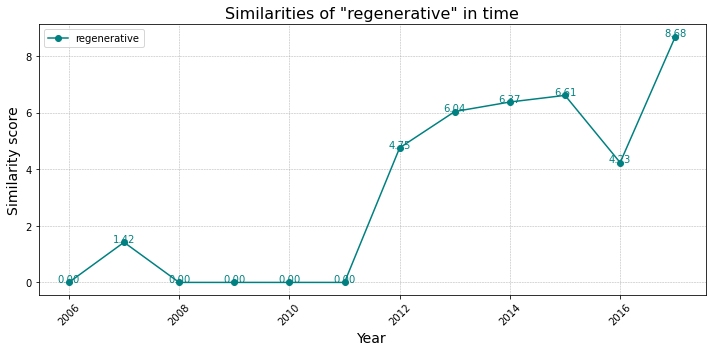

In [53]:
for i, parola in enumerate(highest_scores):
    plt.figure(figsize=(10, 5))
    
    color = colors[i % len(colors)]
    
    plt.plot(df_hso.index, df_hso[parola], marker='o', linestyle='-', color=color, label=parola)

    for anno, valore in zip(df_hso.index, df_hso[parola]):
        plt.text(anno, valore, f'{valore:.2f}', color=color, fontsize=10, ha='center')
    
    plt.title(f'Similarities of "{parola}" in time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Similarity score', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.show()